# Handwritten Digit Recognition
***
## Table of Contents
1. [Introduction](#1-introduction)
1. [Loading Data](#2-loading-data)
1. [Device Agnostic-Code](#3-device-agnostic-code)
1. [Understanding Data](#4-understanding-data)
1. [Preparing DataLoader](#5-preparing-dataloader)
1. [Convolutional Neural Network (CNN) Architecture](#6-convolutional-neural-network-cnn-architectures)
    - [TinyVGG Variant](#tinyvgg-variant)
1. [Evaluation Metrics](#7-evaluation-metrics)
1. [Loss Function](#8-loss-function)
    - [Cross-Entropy Loss](#cross-entropy-loss)
1. [Optimiser](#9-optimiser)
1. [Training and Evaluation](#10-training-and-evaluation)
    - [Training Steps](#training-steps)
    - [Testing Steps](#testing-steps)
1. [Results](#11-results)
    - [Overall Performance](#overall-performance)
    - [Classifications](#classifications)
    - [Missclassifications](#missclassifications)
    - [Confusion Matrix](#confusion-matrix)
    - [Conclusion](#conclusion)
1. [References](#12-references)
***

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Introduction

Image recognition is a fundamental and powerful technique in the field of deep learning, renowned for its versatility across a wide range of applications in computer vision.

This project aims to apply convolutional neural networks (CNNs) architectures and implement foundational deep learning models capable of identifying and classifying images of handwritten digits contained in the MNIST dataset. Through this work, key aspects of model architecture, training dynamics, and evaluation metrics are explored, serving as an introduction to practical image recognition with neural networks.

## 2. Loading Data

In [2]:
train_transform = transforms.Compose(
    [
        transforms.Resize(size=(28, 28)),
        transforms.ToTensor(),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(size=(28, 28)),
        transforms.ToTensor(),
    ]
)

train_data = datasets.MNIST(
    root="_datasets",
    train=True,
    download=True,
    transform=train_transform,
    target_transform=None,
)

test_data = datasets.MNIST(
    root="_datasets",
    train=False,
    download=True,
    transform=test_transform,
)

## 3. Device Agnostic-Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

In [3]:
# Set device
# device = "cuda" if torch.cuda.is_available() else "cpu"  # For Windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # For Mac
device

device(type='mps')

## 4. Understanding Data

In [4]:
print(
    f"Data size\n X_train: {len(train_data.data)}, X_test: {len(test_data.data)}\n y_train: {len(train_data.targets)}, y_test: {len(test_data.targets)}"
)

Data size
 X_train: 60000, X_test: 10000
 y_train: 60000, y_test: 10000


In [5]:
image, label = train_data[0]

In [6]:
image.shape

torch.Size([1, 28, 28])

The shape of the image tensor `[1, 28, 28]`  refers to `[colour channel, height, width]`. Having only one colour channel indicates that the image is grayscale, whereas having three colour scales implies a colourful image based on the red, green and blue (RGB model).

In [7]:
label

5

In [8]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

The MNIST dataset contains 10 different digits (from 0 to 10) with more or less balanced number of samples in each class.

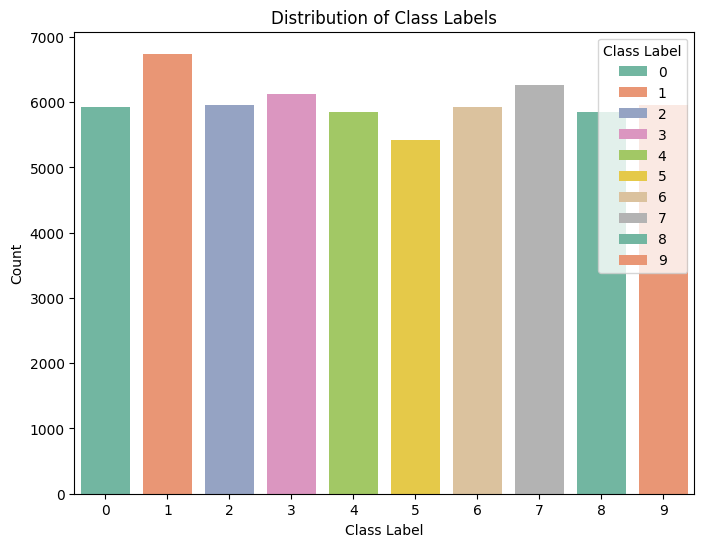

In [9]:
targets = train_data.targets.numpy()
unique_vals, counts = np.unique(targets, return_counts=True)
df_dist = pd.DataFrame({"Class Label": unique_vals, "Count": counts})

plt.figure(figsize=(8, 6))
sns.barplot(data=df_dist, x="Class Label", y="Count", hue="Class Label", palette="Set2")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of Class Labels")
plt.show()

Image Shape: torch.Size([1, 28, 28])


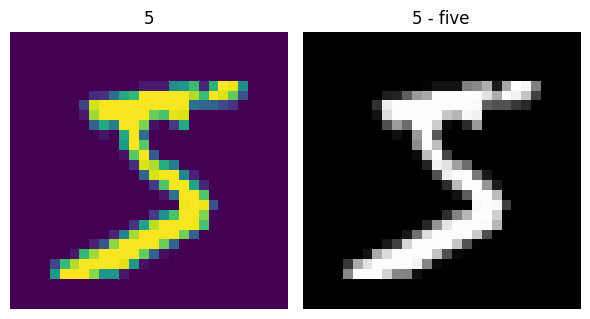

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 9))
axes[0].imshow(image.squeeze())
axes[0].set_title(label)
axes[1].imshow(image.squeeze(), cmap="gray")
axes[1].set_title(class_names[label])

print(f"Image Shape: {image.shape}")
axes[0].axis(False)
axes[1].axis(False)
plt.tight_layout()
plt.show()

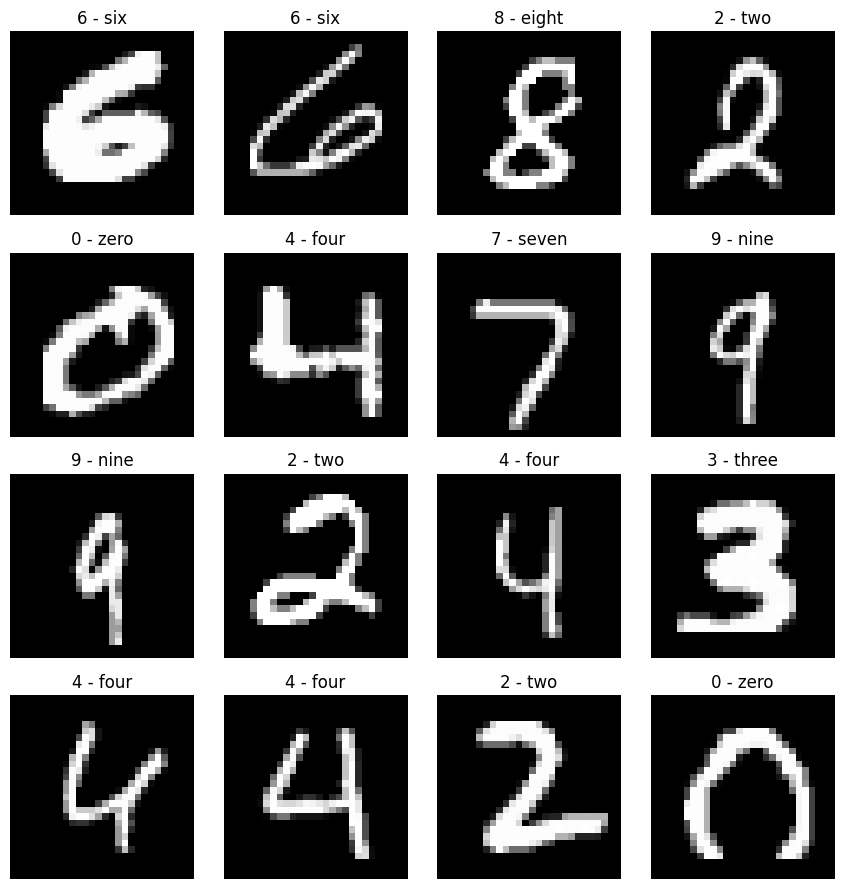

In [11]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(low=0, high=len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
    plt.tight_layout()
plt.show()

## 5. Preparing DataLoader
`torch.utils.data.DataLoader()` increases the computational efficiency by dividing a large dataset into smaller chunks (called **batches** or **mini-batches**). The size of these batches is controlled by the hyperparameter `batch_size`. Processing data in batches allows gradient descent to be performed once per batch rather than once per epoch, facilitating faster and more stable training process. 

By setting `shuffle=True`, the order of the samples is randomised to promote effective learning and reduce bias of the model. Shuffling should be enabled only for training data, not for test data to ensure reproducible and unbiased evaluation.

Typically, the value of the hyperparameter `batch_size` is set as a power of 2 (32, 64, 128, etc.). For example, with `batch_size = 32`, the `train_data` (60000 samples) will be converted to a `train_dataloader` (60000 // 32 = 1875 samples per batch), and the `test_data` (10000 samples) will be converted to a `test_dataloader` (10000 // 32 = 313 samples per batch).

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")


Length of train_dataloader: 1875
Length of test_dataloader: 313


In [13]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 6. Convolutional Neural Network (CNN) Architectures
### TinyVGG Variant
(Inspired by [TinyVGG](https://tinyvgg.streamlit.app/))

The following `CNN` class defines a convolutional neural network architecture appropriate for tasks such as image classifiacation. It is consists of three blocks:

1. **Block 1**: Initial Feature Extraction
    - First Conv2d Layer
        - Takes the image tensor with `input_shape` channels and extracts `hidden_units` feature maps.
    - First ReLU Activation
        - Adds non-linearity, enabling the network to approximate complex functions.
    - Second Conv2d Layer
        - Further refining feature extraction.
    - Second ReLU Activation
        - Continued non-linear transformation after each convolution.
    - MaxPool2d
        - Reduces spatial dimensions by taking the maximum value in each $2 \times 2$ patch. This adds translational invariance and reduces computational requirements.
2. **Block 2**: High-Level Feature Extraction
    - Same structure as block 1 for further feature refinement, capturing larger scale patterns, and spatial dimensions are halved again.
3. **Classifier Block**:
    - Flatten
        - Converts the output feature maps to a single vector per sample, suitable for input to a linear (fully connected) layer.
    - Linear (Fully connected layer)
        - Final classifier layer. After two `nn.MaxPool2d(kernel_size=2)` operations (each halving width and height), dimensions change as $28 \times 28 \rightarrow 14 \times 14 \rightarrow 7 \times 7$. Thus `hidden_units * 7 * 7` matches the expected input size for the linear classifier. 

To improve the performance of CNN model, some actions can be taken on model architecture improvements, such as:
- Add Batch Normalisation Layers
    - Adding batch normalisation layers after each convolutional layer can etablise and accelerate training by normalising the input to each activation function.
- Use Dropout
    - Randomly drop out units during training, making the network less sensitive to the specific weights of individual neurons.
    - Adding `nn.Dropout()` layers, typically after pooling layers or optionally after activation functions to help prevent overfitting.
    - `nn.Dropout2d()` after activations / poolings, and `nn.Dropout()` before fully-connected layer.
- Enhance the Classifier Head
    - Use more than one linear layer in the classifier.

In [14]:
class CNN(nn.Module):
    def __init__(
        self,
        input_shape: int,
        hidden_units: int,
        output_shape: int,
    ):
        super(CNN, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Dropout2d(p=0.1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape),
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [15]:
torch.manual_seed(42)

model_cnn = CNN(
    input_shape=1,
    hidden_units=32,
    output_shape=(len(class_names)),
).to(device)

In [16]:
from torchinfo import summary

summary(
    model_cnn,
    input_size=(
        32,
        1,
        28,
        28,
    ),  # (batch_size, colour channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CNN (CNN)                                [32, 1, 28, 28]      [32, 10]             --                   True
├─Sequential (block_1)                   [32, 1, 28, 28]      [32, 32, 12, 12]     --                   True
│    └─Conv2d (0)                        [32, 1, 28, 28]      [32, 32, 26, 26]     320                  True
│    └─ReLU (1)                          [32, 32, 26, 26]     [32, 32, 26, 26]     --                   --
│    └─Dropout2d (2)                     [32, 32, 26, 26]     [32, 32, 26, 26]     --                   --
│    └─Conv2d (3)                        [32, 32, 26, 26]     [32, 32, 24, 24]     9,248                True
│    └─ReLU (4)                          [32, 32, 24, 24]     [32, 32, 24, 24]     --                   --
│    └─MaxPool2d (5)                     [32, 32, 24, 24]     [32, 32, 12, 12]     --                   --
│    └─Dropout2d (6)  

## 7. Evaluation Metrics
We will use the following evaluation metrics:
- `torchmetrics.Accuracy`
- `torchmetrics.Precision`
- `torchmetrics.Recall`
- `torchmetrics.F1Score`

In [17]:
from torchmetrics import Accuracy, Precision, Recall, F1Score

n_classes = len(class_names)

calculate_accuracy = Accuracy(task="multiclass", num_classes=n_classes).to(device)
calculate_precision = Precision(
    task="multiclass", num_classes=n_classes, average="macro"
).to(device)
calculate_recall = Recall(task="multiclass", num_classes=n_classes, average="macro").to(
    device
)
calculate_f1 = F1Score(task="multiclass", num_classes=n_classes, average="macro").to(
    device
)

metrics = [calculate_accuracy, calculate_precision, calculate_recall, calculate_f1]

## 8. Loss Function
### Cross-Entropy Loss
Cross-Entropy Loss is a loss function used for classification problems, particularly when the model outputs probabilities using a softmax activation in the final layer. It measures the difference between the true labels and the predicted probability distribution.

For a single data point, the cross-entropy loss is defined as:

\begin{align*}
    L = - \sum^{k}_{i=1}y_{i}\log{(\hat y_{i})}
\end{align*}

where:
- $y_i$: True label for the $i$-th class. If one-hot encoded, $y_{i} = 1$ for the corrected class, $y_{i} = 0$ otherwise.
- $\hat y_i$: Predicted probability for the $i$-th class.
- $k$: Number of classes.

For a batch of $m$ data point:

\begin{align*}
    C = \dfrac{1}{m} \sum^{m}_{j=1} \left (- \sum^{k}_{i=1}y_{j, i}\log{(\hat y_{j, i})} \right)
\end{align*}

where:
- $C$: Average cross-entropy loss over the batch.
- $m$: Number of training examples (batch size).
- $k$: Number of classes.
- $y_{j, i} \in { 0, 1}$: Indicator that true class for sample $j$ corresponds to class $i$.
- $\hat y_{j, i} \in { 0, 1}$: Predicted probability for sample $j$ belonging to class $i$.

In PyTorch:
- Use `nn.CrossEntropyLoss()` directly with raw logits.
- Do not apply `Softmax()` or `LogSoftmax()` manually before the loss.
- Internally, `nn.CrossEntropyLoss() = LogSoftmax() + NegativeLogLikelihoodLoss()`. 

In [18]:
loss_function = nn.CrossEntropyLoss()

## 9. Optimiser
An optimiser in neural networks is used to adjust the parameters (weights and biases) of a model during training to minimise the loss. Optimisers are essential for enabling neural networks to learn from data: without them, the model would not improve over time.

In [19]:
optimiser = torch.optim.Adam(params=model_cnn.parameters(), lr=0.001)

## 10. Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss and evaluation metrics per batch.
1. For each epoch, iterate through testing batches, perform testing steps, calculate the test loss and evaluation metrics per batch.
1. Store the results.

### **Training Steps**
1. Forward Pass
    - Pass inputs through the model to obtain predictions.
1. Calculate Loss Per Batch
    - Measure how far the predictions deviate from the true labels, using a loss function.
1. Zero the Gradients
    - Clear the previously stored gradients to prevent accumulation from multiple backward passes.
1. Backward Pass
    - Computes gradients of the loss with respect to the model's parameters via backpropagation.
1. Optimiser Step
    - Update the parameter $\theta$ using the gradients just computed, typically following an equation such as:
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average Training Loss
    - Computes the mean training loss across all batches for the epoch.

In [20]:
def train_step(
    model: nn.Module,
    data_loader: DataLoader,
    loss_function: nn.Module,
    optimiser: torch.optim.Optimizer,
    calculate_accuracy: torch.optim.Adam,
    device: torch.device = device,
):
    model.to(device)
    model.train()  # Set the model to evaluation mode
    train_loss = 0
    for metric in metrics:
        metric.reset()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss per batch
        loss = loss_function(y_pred, y)
        train_loss += loss.item()

        for metric in metrics:
            metric.update(y_pred, y)

        # 3. Optimiser zero grad
        optimiser.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimiser step
        optimiser.step()

        if batch % 500 == 0:
            print(f"{batch * len(X)}/{len(data_loader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(data_loader)
    train_acc = calculate_accuracy.compute().item() * 100
    train_prec = calculate_precision.compute().item() * 100
    train_rec = calculate_recall.compute().item() * 100
    train_f1 = calculate_f1.compute().item() * 100
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    train_metrics = [train_acc, train_prec, train_rec, train_f1]
    return train_loss, train_metrics


### **Testing Steps**
1. Forward pass
    - Set the model to evaluation mode (which disables dropout and batch normalisation and desactivates gradient tracking for safety).
    - Pass inputs through the model to obtain predictions.
1. Calculate Loss Per Batch
    - Measure how far the predictions deviate from the true labels, using a loss function.
1. Update and Compute Accuracy
    - Updates accuracy state with each batch, and compute the overall accuracy after all test batches.
1. Average Test Loss
    - Computes the mean Test loss across all batches for the epoch.

In [21]:
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_function: torch.nn.Module,
    calculate_accuracy,
    device: torch.device = device,
):
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    for metric in metrics:
        metric.reset()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss
            test_loss += loss_function(test_pred, y).item()

            # 3. Calculate metrics
            for metric in metrics:
                metric.update(test_pred, y)

        # 4. Take the averages of test loss and compute metrics
        test_loss /= len(data_loader)
    test_acc = calculate_accuracy.compute().item() * 100
    test_prec = calculate_precision.compute().item() * 100
    test_rec = calculate_recall.compute().item() * 100
    test_f1 = calculate_f1.compute().item() * 100
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    test_metrics = [test_acc, test_prec, test_rec, test_f1]
    return test_loss, test_metrics

In [22]:
EPOCHS = 10
epochs_range = range(1, EPOCHS + 1)
train_losses, train_accuracies, train_precisions, train_recalls, train_f1s = (
    [],
    [],
    [],
    [],
    [],
)
test_losses, test_accuracies, test_precisions, test_recalls, test_f1s = (
    [],
    [],
    [],
    [],
    [],
)

for epoch in epochs_range:
    print(f"Epoch: {epoch}\n==========")
    train_loss, train_metrics = train_step(
        data_loader=train_dataloader,
        model=model_cnn,
        loss_function=loss_function,
        optimiser=optimiser,
        calculate_accuracy=calculate_accuracy,
        device=device,
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_metrics[0])
    train_precisions.append(train_metrics[1])
    train_recalls.append(train_metrics[2])
    train_f1s.append(train_metrics[3])

    test_loss, test_metrics = test_step(
        data_loader=test_dataloader,
        model=model_cnn,
        loss_function=loss_function,
        calculate_accuracy=calculate_accuracy,
        device=device,
    )
    test_losses.append(test_loss)
    test_accuracies.append(test_metrics[0])
    test_precisions.append(test_metrics[1])
    test_recalls.append(test_metrics[2])
    test_f1s.append(test_metrics[3])

Epoch: 1
0/60000 samples
16000/60000 samples
32000/60000 samples
48000/60000 samples
Train loss: 0.17219 | Train accuracy: 94.65%
Test loss: 0.04860 | Test accuracy: 98.43%

Epoch: 2
0/60000 samples
16000/60000 samples
32000/60000 samples
48000/60000 samples
Train loss: 0.06471 | Train accuracy: 98.08%
Test loss: 0.02983 | Test accuracy: 98.96%

Epoch: 3
0/60000 samples
16000/60000 samples
32000/60000 samples
48000/60000 samples
Train loss: 0.05108 | Train accuracy: 98.44%
Test loss: 0.02912 | Test accuracy: 98.99%

Epoch: 4
0/60000 samples
16000/60000 samples
32000/60000 samples
48000/60000 samples
Train loss: 0.04330 | Train accuracy: 98.66%
Test loss: 0.03240 | Test accuracy: 98.91%

Epoch: 5
0/60000 samples
16000/60000 samples
32000/60000 samples
48000/60000 samples
Train loss: 0.03831 | Train accuracy: 98.83%
Test loss: 0.02408 | Test accuracy: 99.31%

Epoch: 6
0/60000 samples
16000/60000 samples
32000/60000 samples
48000/60000 samples
Train loss: 0.03459 | Train accuracy: 98.90%


In [23]:
print(f"Final Loss: {test_loss:.4f} | Final Test accuracy: {test_metrics[0]:.2f}%")

Final Loss: 0.0206 | Final Test accuracy: 99.35%


## 11. Results
### Overall Performance

In [24]:
train_metrics = {
    "Loss": train_losses,
    "Accuracy": train_accuracies,
    "Precision": train_precisions,
    "Recall": train_recalls,
    "F1 Score": train_f1s,
}
test_metrics = {
    "Loss": test_losses,
    "Accuracy": test_accuracies,
    "Precision": test_precisions,
    "Recall": test_recalls,
    "F1 Score": test_f1s,
}

In [25]:
def plot_results(epochs_range, train_metrics, test_metrics) -> None:
    metrics_names = list(train_metrics.keys())
    n_metrics = len(metrics_names)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
    axes = axes.flatten()

    for i, metric_name in enumerate(metrics_names):
        ax = axes[i]
        ax.plot(
            epochs_range, train_metrics[metric_name], label=f"Train {metric_name}"
        )  # Train metric
        ax.plot(
            epochs_range, test_metrics[metric_name], label=f"Test {metric_name}"
        )  # Test metric
        ax.set_title(f"{metric_name} Over Epochs", fontsize=15)
        ax.legend()
        ax.set_xlabel("Epoch")
        if metric_name == "Loss":
            ax.set_ylabel("Loss")
        else:
            ax.set_ylabel(f"{metric_name} (%)")

    if n_metrics < len(axes):
        for j in range(n_metrics, len(axes)):
            plt.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


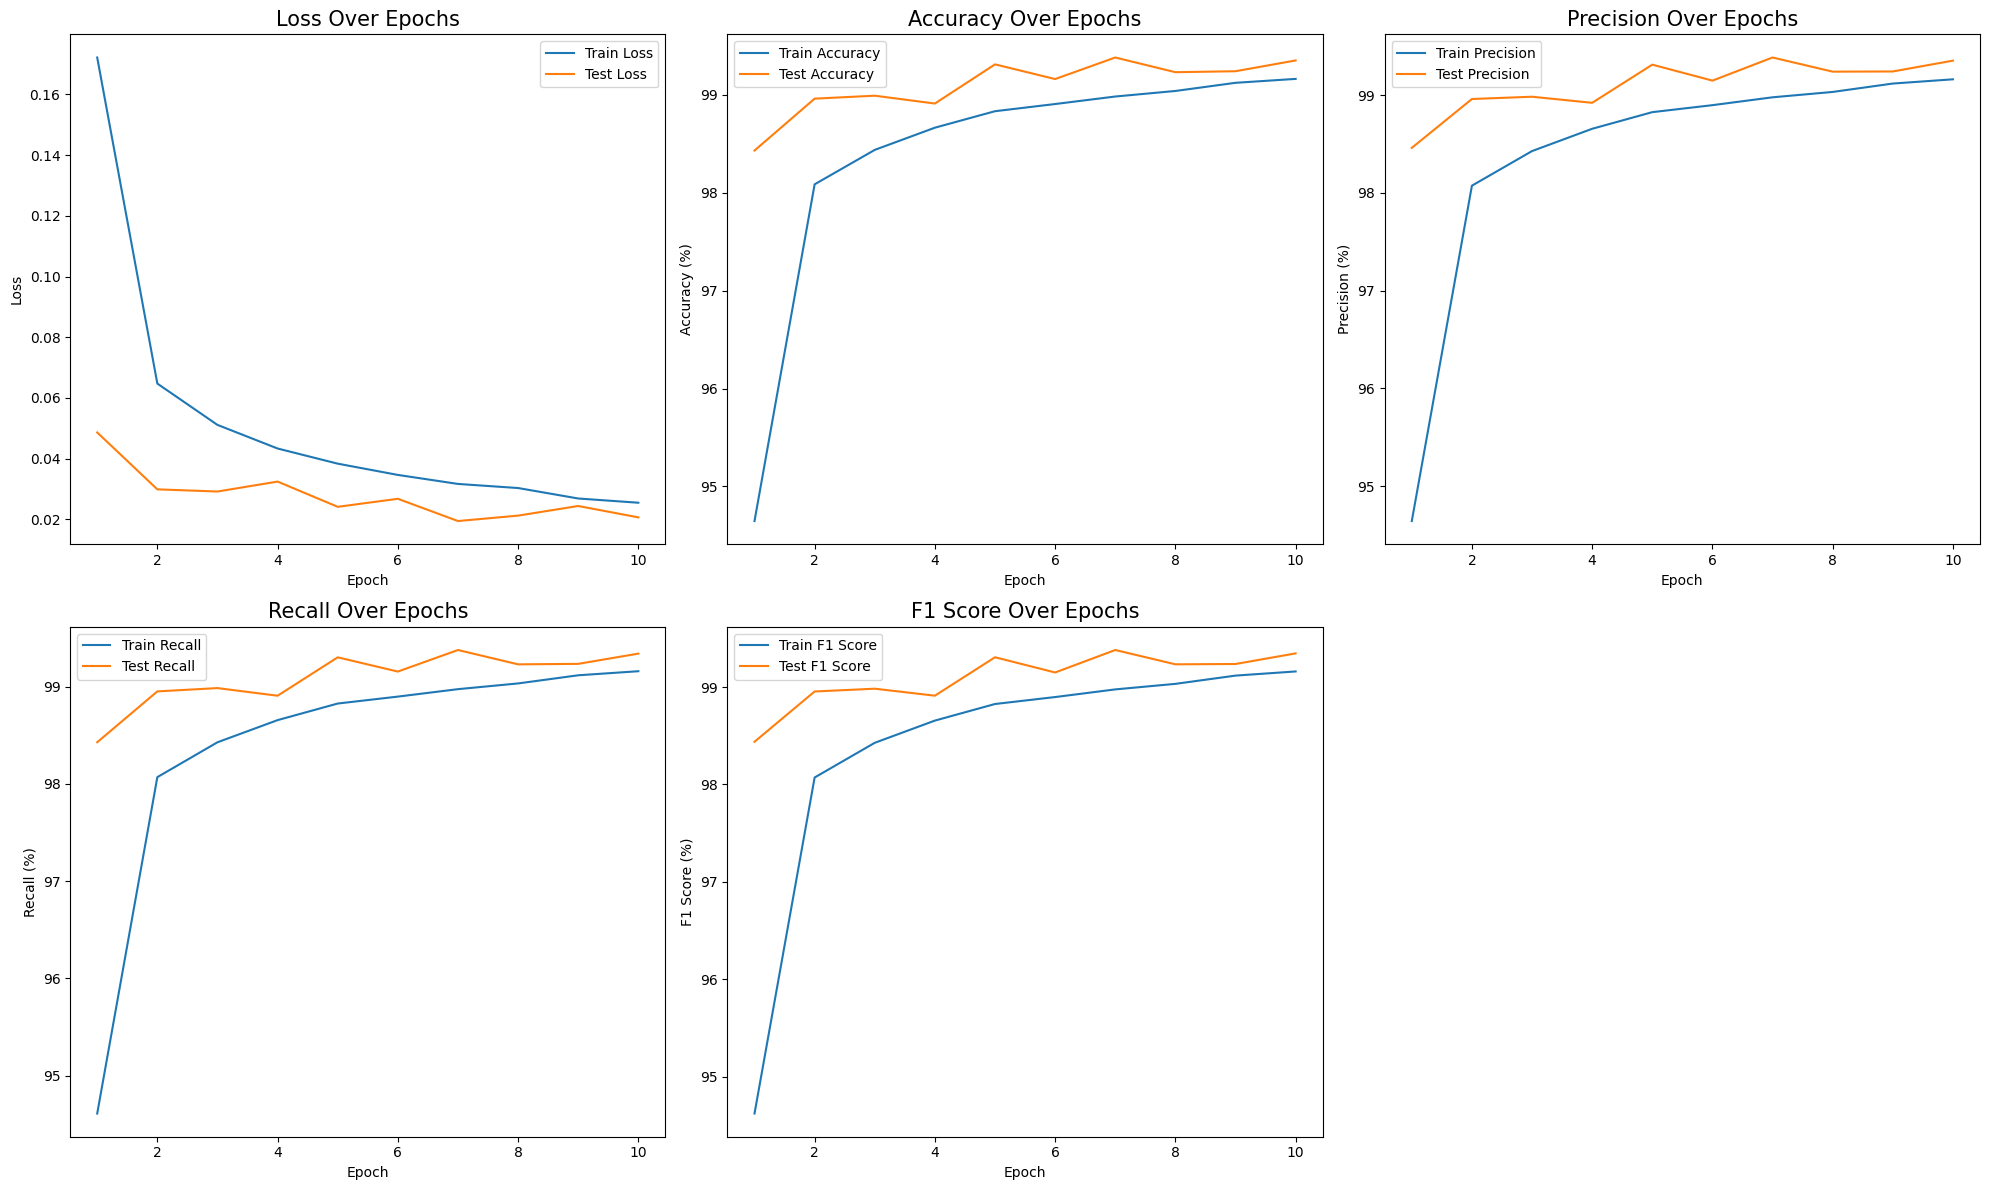

In [26]:
plot_results(epochs_range, train_metrics, test_metrics)

### Classifications

Randomly sampling (`k=9`) from the test dataset:

In [27]:
import random

random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}")
print(f"Test sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


The following `make_predictions()` function takes a model and arbitrary input data to generate predictions. By passing the unsqueezed sample data through the model in a forward pass, a raw logit is returned. This raw logit is subsequently converted into a prediction probability by applying the `torch.softmax()` function.

In [28]:
def make_predictions(model: nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(
                device
            )  # Add an extra dimension and send sample to device

            # Forward pass
            pred_logit = model(sample)

            # Get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    # torch.stack to convert list to tensor
    return torch.stack(pred_probs)


In [29]:
pred_probs = make_predictions(model=model_cnn, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
print(f"Predicted labels: {pred_classes}\nTrue labels: {test_labels}")

Predicted labels: tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])
True labels: [2, 1, 2, 4, 6, 6, 4, 9, 1]


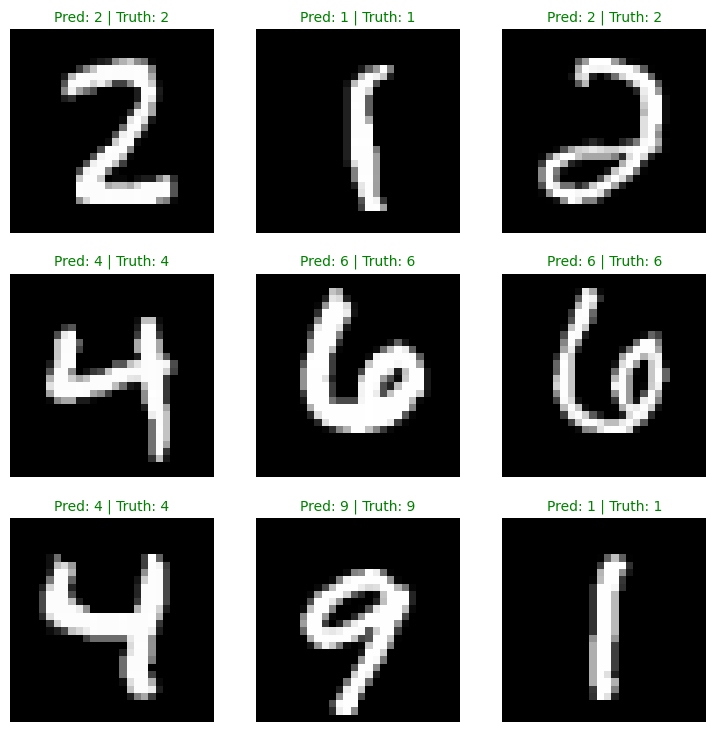

In [30]:
plt.figure(figsize=(9, 9))
for i, sample in enumerate(test_samples):
    plt.subplot(3, 3, i + 1)

    plt.imshow(sample.squeeze(), cmap="gray")

    pred_label = pred_classes[i]

    true_label = test_labels[i]

    title_text = f"Pred: {pred_label} | Truth: {true_label}"

    if pred_label == true_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)
plt.show()

To make predictions on the entire test dataset:

In [31]:
def make_all_predictions(
    model: nn.Module, data: DataLoader, device: torch.device = device
):
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in data:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_logit = model(X)

            # Get prediction probability
            y_prob = torch.softmax(y_logit, dim=1)

            # Get predictions
            y_pred = y_prob.argmax(dim=1)
            y_preds.append(y_pred.cpu())
    y_pred_tensor = torch.cat(y_preds)
    return y_pred_tensor

In [32]:
pred_all = make_all_predictions(model=model_cnn, data=test_dataloader)
print(pred_all)

tensor([7, 2, 1,  ..., 4, 5, 6])


### Misclassifications

In [33]:
all_test_samples = []
all_test_labels = []
for sample, label in test_dataloader:
    all_test_samples.append(sample)
    all_test_labels.append(label)
all_test_samples = torch.cat(all_test_samples)
all_test_labels = torch.cat(all_test_labels)

In [34]:
wrong_indices = (all_test_labels != pred_all).nonzero(as_tuple=True)[0]

In [35]:
print(
    f"Number of failed predictions: {len(wrong_indices)}/{len(all_test_labels)} ({100.0 * len(wrong_indices) / len(all_test_labels):.2f}%)"
)

Number of failed predictions: 65/10000 (0.65%)


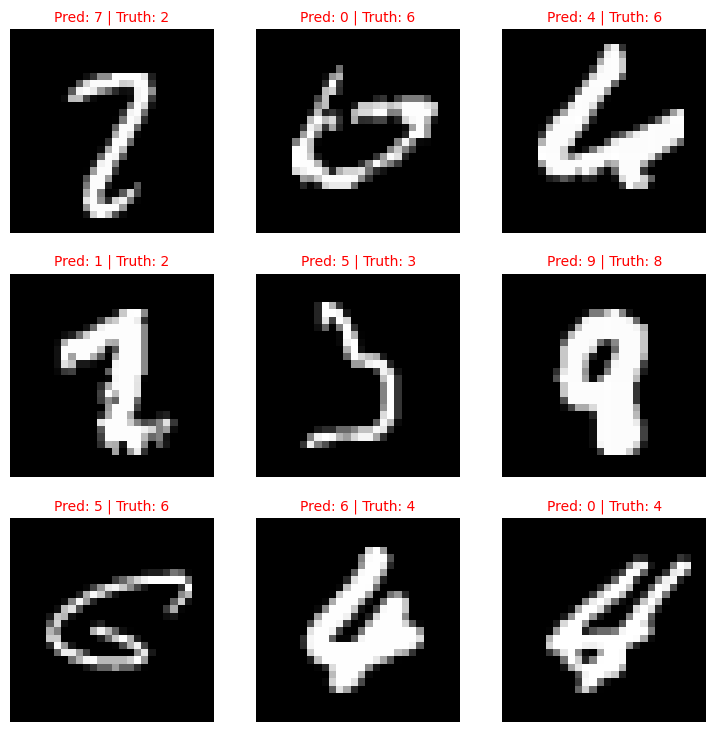

In [36]:
plt.figure(figsize=(9, 9))
wrong_pred_count = 0
max_images = 9

for i in wrong_indices:
    if wrong_pred_count >= max_images:
        break
    plt.subplot(3, 3, wrong_pred_count + 1)

    plt.imshow(all_test_samples[i].squeeze(), cmap="gray")

    pred_label = pred_all[i]

    true_label = all_test_labels[i]

    title_text = f"Pred: {pred_label} | Truth: {true_label}"

    plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)
    wrong_pred_count += 1
plt.show()

### Confusion Matrix

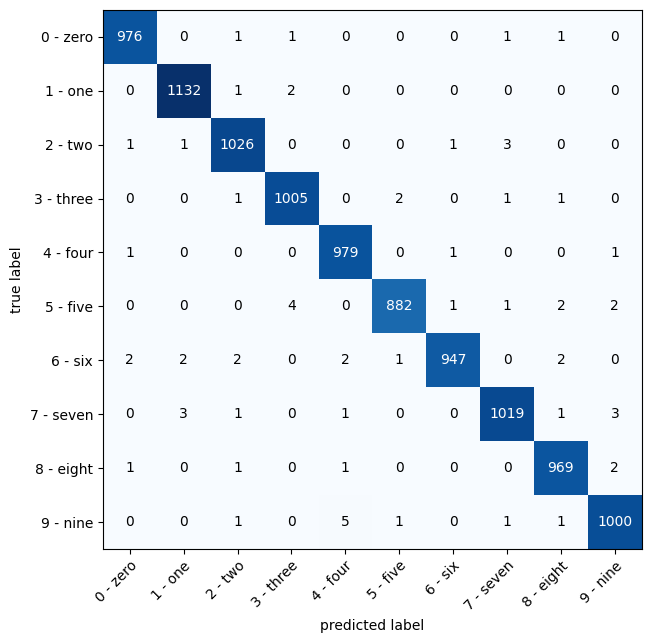

In [37]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
conf_matrix_tensor = conf_matrix(preds=pred_all, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix_tensor.numpy(),  # Requires numpy type
    class_names=class_names,
    figsize=(10, 7),
)

### Conclusion
After 10 epochs, our CNN model achieved an accuracy of $99.35$% on the test dataset (misclassification rate of $0.65$%). The confusion matrix illustrates the number of images correctly and incorrectly classified by the model for each label. Notably, images depicting the digit $9$ were most frequently confused with those depicting $4$, and those of $5$ with $3$. These cases are particularly challenging, as such digits can be difficult to distinguish depending on the individual's handwriting style.

## 12. References

1. Wang, Z.J., Turko, R., Shaikh, O., Park, H., Das, N., Hohman, F., Kahng, M., Chau, D.H. (2020). *CNN Explainer: Learning  Convolutional Neural Networks with Interactive Visualization*. arXiv preprint<br>
[arXiv:2004.15004](https://arxiv.org/abs/2004.15004).

1. Daniel Bourke. (2022). *03. PyTorch Computer Vision*.<br>
https://www.learnpytorch.io/03_pytorch_computer_vision/#5-setup-device-agnostic-code-for-using-a-gpu-if-there-is-one

1. GeeksforGeeks. (2025). *Optimization Rule in Deep Neural Networks*.<br>
https://www.geeksforgeeks.org/deep-learning/optimization-rule-in-deep-neural-networks/

1. Umar Balak. (2024). *TinyVGG*. <br>
https://tinyvgg.streamlit.app/